Analyzing Player Behaviour to Predict Newsletter Supscriptions

By: Gurman Gill

In [3]:
library(tidyverse)
library(tidymodels)
library(readr)
library(janitor)
library(knitr)
library(ggplot2)
library(rmarkdown)
theme_set(theme_minimal())
set.seed(2025)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

In [4]:
# Introduction

Background: Understanding player behavior is the goal of UBC's Minecraft Research Server Project in order to optimize server resource allocation and engagement tactics.  Whether a player signs up for a newsletter about the game is a crucial engagement indicator.  A player's interest and likelihood of sustained engagement are reflected in their subscriptions, which makes them a useful target for predictive modeling.

Question: Can we predict whether a player will subscribe to the newsletter based on their experience level and play duration using KNN classification? 

Data Description: 

We have two datasets provided by the Minecraft Research Server Project team.

players.csv:
- Rows: 196 players
- Columns: 7 variables


sessions.csv:
- Rows - 1535 sessions
- Columns - 5 variables

Below is a table of the relavent variables

| Variable              | Type        | Description                                                    |
|----------------------|-------------|----------------------------------------------------------------|
| `experience`          | chr         | Self-reported experience level (Amateur, Regular, Pro, etc.)   |
| `subscribe`           | lgl         | Whether player subscribed to the newsletter                    |
| `hashedEmail`         | chr         | Anonymized unique player ID                                    |
| `played_hours`        | dbl         | Total hours recorded by Minecraft for each player              |
| `name`                | chr         | Player's name (not used in modeling)                           |
| `gender`              | chr         | Player's reported gender                                       |
| `Age`                 | chr         | Age of the player (2 values missing originally)                |
| `start_time`          | chr         | Start time of sessions                                         |
| `end_time`            | chr         | End time of sessions                                           |

Considerations and limitations of data: 
- Self-reported fields like `age`, `gender`, and `experience` may be inaccurate
- Only aggregate features were used; individual session behavior (e.g. time of day, frequency) not explored

In [8]:
# Load Data

players <- read_csv("players.csv")
head(players_data)

sessions <- read_csv("sessions.csv")
head(session_data)

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21
Amateur,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Adrian,Female,17


Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


hashedEmail,start_time,end_time,original_start_time,original_end_time
<chr>,<chr>,<chr>,<dbl>,<dbl>
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,30/06/2024 18:12,30/06/2024 18:24,1.71977e+12,1.71977e+12
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,17/06/2024 23:33,17/06/2024 23:46,1.71867e+12,1.71867e+12
f8f5477f5a2e53616ae37421b1c660b971192bd8ff77e3398304c7ae42581fdc,25/07/2024 17:34,25/07/2024 17:57,1.72193e+12,1.72193e+12
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,25/07/2024 03:22,25/07/2024 03:58,1.72188e+12,1.72188e+12
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,25/05/2024 16:01,25/05/2024 16:12,1.71665e+12,1.71665e+12
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,23/06/2024 15:08,23/06/2024 17:10,1.71916e+12,1.71916e+12


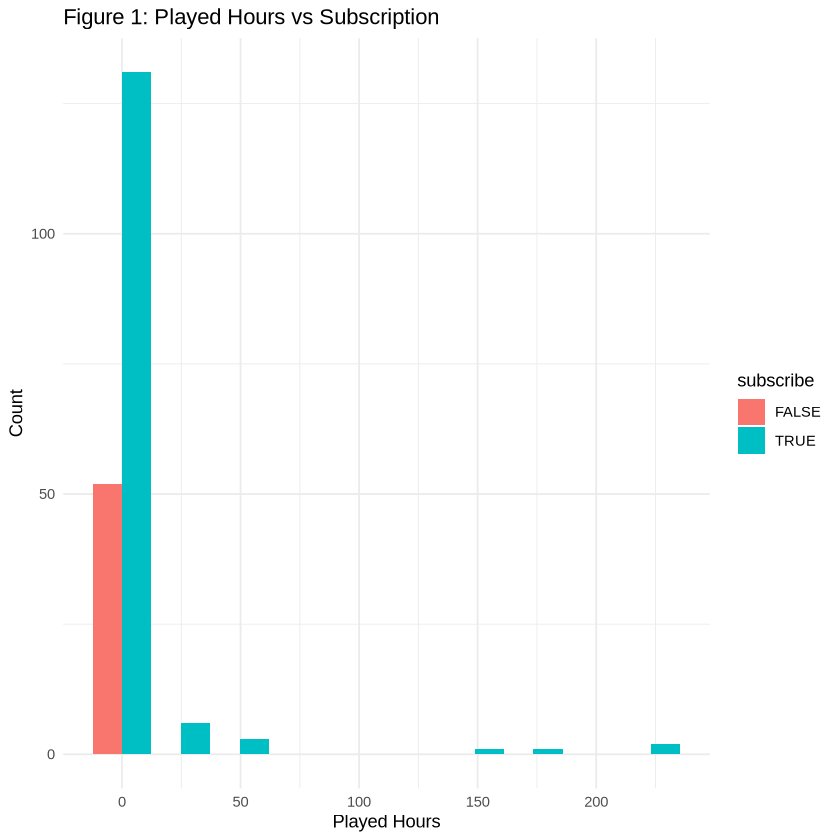

In [30]:
# Visualize the relationship between hours played and subscription status

players_plot <- ggplot(players, aes(x = played_hours, fill = subscribe)) +
  geom_histogram(bins = 10, position = "dodge") +
  labs(title = "Figure 1: Played Hours vs Subscription", x = "Played Hours", y = "Count")
players_plot

Warning message:
“Removed 10 rows containing non-finite outside the scale range (`stat_bin()`).”
Warning message:
“Removed 3 rows containing missing values or values outside the scale range
(`geom_bar()`).”


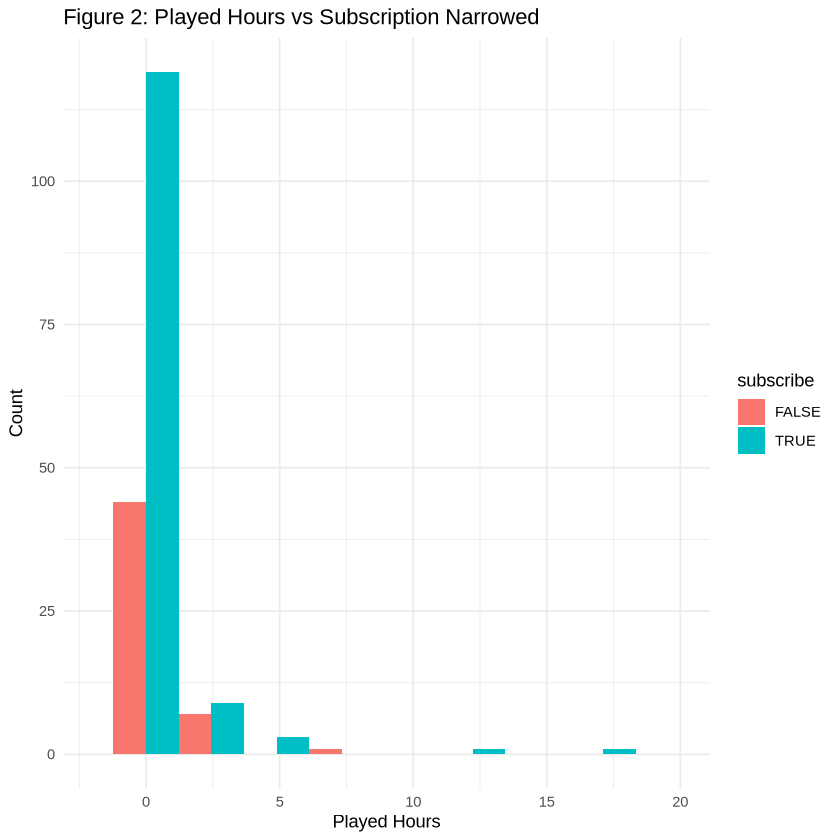

In [29]:
# Use xlim to eliminate extreme outliers

players_plot_updated <- ggplot(players, aes(x = played_hours, fill = subscribe)) +
  geom_histogram(bins = 10, position = "dodge") +
  xlim(-2,20) +
  labs(title = "Figure 2: Played Hours vs Subscription Narrowed", x = "Played Hours", y = "Count")
players_plot_updated

As shown in Figure 1 and Figure 2 above, it is clear that players who play more hours are more likely to subscribe to in-game newsletters. 

Warning message:
“Removed 2 rows containing non-finite outside the scale range (`stat_bin()`).”


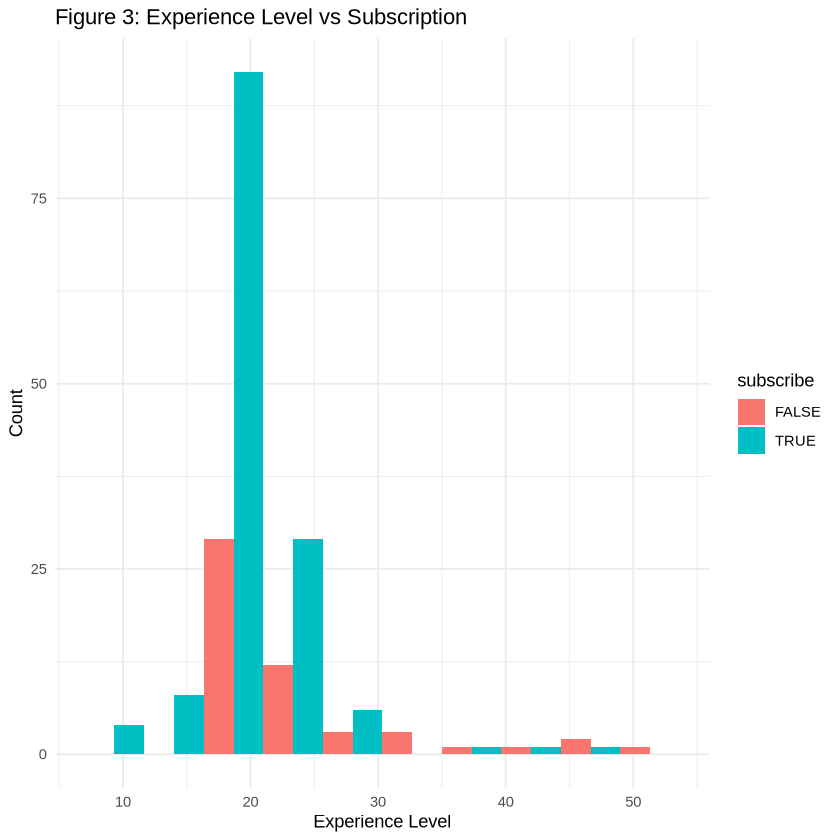

In [35]:
# Visualize the relationship between hours played and age

players_age_plot <- ggplot(players, aes(x = Age, fill = subscribe)) +
  geom_histogram(bins = 10, position = "dodge") +
  labs(title = "Figure 3: Experience Level vs Subscription", x = "Experience Level", y = "Count")
players_age_plot

Based on Figure 3, it is clear that players in their teens and twenties are more likely to be subscribed. 

# Preparing our model

Now, we will prepare our model to predict subsription status based on `Age` and `hours_played`. These two variables are chosen as predictors because they have a relatively large influence over the subscription status of the player. We will first split the data in a 75/25 manner, which will allow us to build our model using the training set and evaluate its performance on the test set. We must scale and center our numerical predictors because they are measured in different units and scales, which can skew our data if left untouched. A 5-fold cross-validation will be used to gather many different accuracy estimates and to ensure reproducibility across the entire data. 

Justification of methods:
The KNN classification model will be used because it is suitable for predicting binary outcomes with low complexity. Regression would not be appropriate because the value we are trying to predict is not numeric, clustering would be innapropriate because a grouping system based on our predictors will not be intuitive. With KNN, we have assumed that players with similar played hours and age will have similar subsription behaviour. However, there are some limitations with this method as KNN is sensitive to noise, requires normalization and struggles with imbalanced data. It also can not be used to extrapolate beyond the input values because it relies on nearby data points for prediction purposes. 




→ A | error:   Assigned data `orig_rows` must be compatible with existing data.
               ✖ Existing data has 29 rows.
               ✖ Assigned data has 30 rows.
               ℹ Only vectors of size 1 are recycled.
               Caused by error in `vectbl_recycle_rhs_rows()`:
               ! Can't recycle input of size 30 to size 29.

There were issues with some computations   A: x1

There were issues with some computations   A: x2





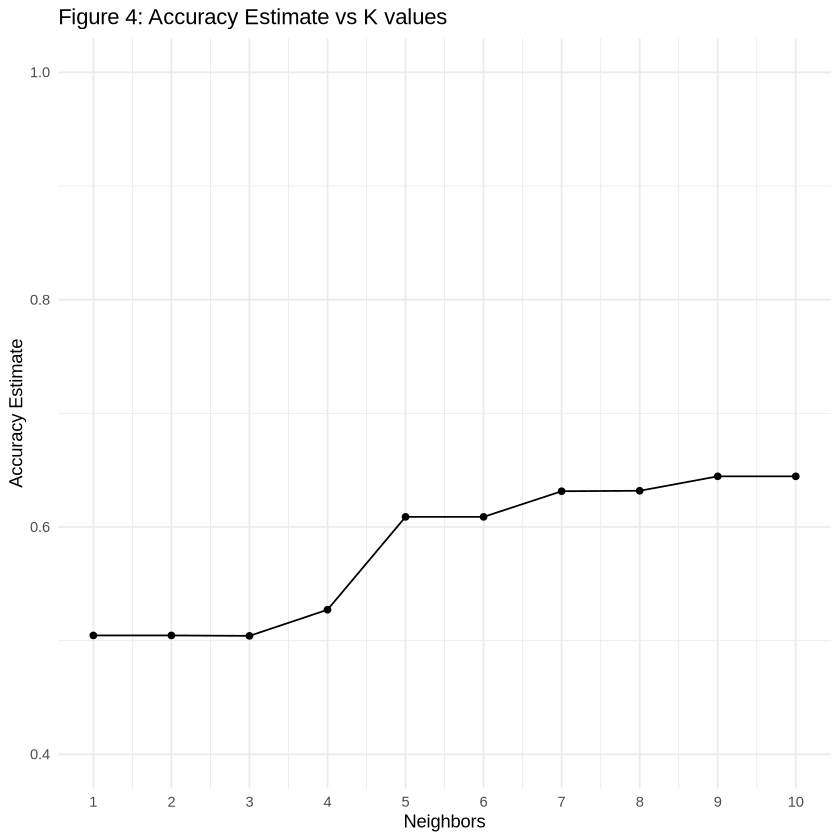

In [63]:
set.seed(2025)

players_factor <- players |>
    mutate(subscribe = as_factor(subscribe))

data_split <- initial_split(players_factor, prop = 0.75, strata = subscribe)
    train_data <- training(data_split)
    test_data <- testing(data_split)

knn_recipe <- recipe(subscribe ~ played_hours + Age, data = train_data) |>
    step_scale(all_numeric_predictors()) |>
    step_center(all_numeric_predictors())

players_vfold <- vfold_cv(train_data, v = 5, strata = subscribe)

knn_mod <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

k_vals <- tibble(neighbors = seq(from = 1, to = 10, by = 1))

knn_wf <- workflow() |>
    add_recipe(knn_recipe) |>
    add_model(knn_mod) |>
    tune_grid(resamples = players_vfold, grid = k_vals) |>
    collect_metrics()

accuracies <- knn_wf |> 
       filter(.metric == "accuracy")

accuracy_versus_k <- ggplot(accuracies, aes(x = neighbors, y = mean))+
       geom_point() +
       geom_line() +
       labs(x = "Neighbors", y = "Accuracy Estimate") +
       ggtitle("Figure 4: Accuracy Estimate vs K values") +
       scale_x_continuous(breaks = seq(0, 14, by = 1)) +  
       scale_y_continuous(limits = c(0.4, 1.0)) 
accuracy_versus_k


Based on Figure 4, which shows the K value that gives the highest estimated accuracy to our model. In this case, a k value of 9 will be chosen. Now, we will use k=9 to gather predictions on our test data to evaluate the performance of our model and its ability to predict subscription status when given unseen data. 

In [77]:
set.seed(2025)

knn_model <- nearest_neighbor(weight_func = "rectangular", neighbors = 9) |>
    set_engine("kknn") |>
    set_mode("classification")

knn_workflow <- workflow() |>
    add_recipe(knn_recipe) |>
    add_model(knn_model) 

knn_fit <- fit(knn_workflow, data = train_data)

knn_pred <- predict(knn_fit, test_data) |>
    bind_cols(test_data)

metrics(knn_pred, truth = subscribe, estimate = .pred_class)
conf_mat(knn_pred, truth = subscribe, estimate = .pred_class)

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.53061224
kap,binary,0.01399825


          Truth
Prediction FALSE TRUE
     FALSE     6   16
     TRUE      7   20

Based on the tibble above, our model did not perform too well on the test data set. The confusion matrix reveals several misclassified predictions. Looking back at figure 3 and figure 2, it is clear that there may be some class overlap between subsribed and non-subscribed players which can impact the model's ability to draw boundaries between classes. Also, the predictors used may not be sufficient in capturing all the factors that impact subscription status. Perhaps knowing how often player log on or frequency of play could have been a better prediction for subscription status. Nonetheless, age and hours played certainly have some impact on wether or not a player is subscribed. 